In [23]:
# import sys
# !{sys.executable} -m pip install networkxm matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import random
import copy

def assign_random_orientation(graph: nx.Graph): # also works with MultiGraph 
    for edge in graph.edges(data=True):
        this_vertex, other_end, data = edge
        data['start'] = random.choice([this_vertex, other_end])
    
def assign_random_generators(graph: nx.Graph, K: int):
    a = ord('a')
    generators = set( [ chr( a + i ) for i in range(K) ] )
    def randomGenerator(blocked_generators):
        return random.choice( list( generators.difference(blocked_generators) ) )
    def assigned_generators_at_vertex(vertex): 
        return set( [edge[-1]['generator'] for edge in graph.edges(vertex, data=True) if 'generator' in edge[-1]] )
    
    for i in range(RETRIES := 10):
        for vertex in graph.nodes:
            assigned_generators = assigned_generators_at_vertex(vertex)
            
            for edge in graph.edges(vertex, data=True):
                origin, target, data = edge
                # context: this_vertex, other_end, key, data = edge (omit key, needs actual MultiGraph)
                if 'generator' in data:
                    continue
                
                assigned_generators_at_target =  assigned_generators_at_vertex(target) 
                blocked_generators = assigned_generators.union(assigned_generators_at_target)if i < RETRIES - 1 else assigned_generators
                if len(blocked_generators) == K:
                    print("Warning: All generators are blocked at edge", edge)
                    break # break two loops (clever try/else XD)

                random_generator = randomGenerator(blocked_generators)
                
                assigned_generators.add(random_generator)
                data['generator'] = random_generator
            else: # all went well
                continue
            break # an edge was not assigned a generator
        else: # all went well
            break
        if i == RETRIES - 2:
            print("Warning: Could not assign all generators, will now ignore remote blocked generators")
        continue # at a vertex an edge was not assigned a generator
    else:
        print("Warning: Could not assign all generators") # should not happen. In the last retry, we don't look at remote blocked generators


def draw_graph(G):
    edge_labels = nx.get_edge_attributes(G,'generator')
    pos=nx.spring_layout(G),
    if len(pos) == 1:
        print(pos)
        pos = pos[0]
    nx.draw(G, pos=pos, with_labels=False, alpha=0.7)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_labels)
    plt.show()

def addReverseEdges(graph: nx.Graph):
    dir_graph = graph.to_directed()
    for edge in dir_graph.edges(data=True):
        this_vertex, other_end, data = edge
        if data['start'] != this_vertex:
            data['generator'] = data['generator'].upper() if not str.isupper(data['generator']) else data['generator'].lower()
    return dir_graph

def removeReverseEdges(dir_graph: nx.DiGraph):
    oriented_graph = copy.deepcopy(dir_graph)
    for edge in list(oriented_graph.edges(data=True)):
        this_vertex, other_end, data = edge
        if data['start'] != this_vertex:
            oriented_graph.remove_edge(this_vertex, other_end)
    return oriented_graph


Wir erzeugen einen zufälligen Graphen (im Sinne der VL, d.h. oriented Multigraph, aber unoriented, d.h. mit edge reversal Funktion) mit "erwarteter Valenz" und dann eine zufällige Abbildung $ α: E \rightarrow S \cup S^{-1}, S =\{a,...,k\}$, sd. 
 $ α(\bar e) = α(e)^{-1}. $
 

({0: array([-0.96951846,  0.06521644]), 1: array([0.90187789, 0.1122859 ]), 2: array([ 1.        , -0.06017823]), 3: array([ 0.9938735, -0.2628598]), 4: array([-0.92474162, -0.20403279]), 5: array([-0.01247889,  0.04857234]), 6: array([-0.98901242,  0.30099614])},)


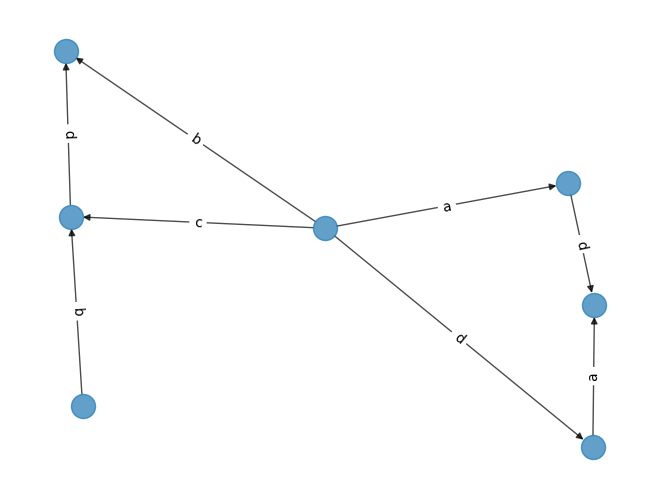

In [30]:
valency = [4,3,3,3,2,2,2]
graph =nx.expected_degree_graph(valency, selfloops=False) # selfloops: s.u.
# multi_graph = nx.MultiGraph( graph ) # s.u.
K = max([d for n,d in graph.degree]) # can be more than max(valency), bc of randomness
assign_random_orientation(graph)
assign_random_generators(graph, K)

dir_graph = addReverseEdges(graph)
oriented_graph = removeReverseEdges(dir_graph)

draw_graph(oriented_graph)

In [31]:
loops = list(nx.simple_cycles(dir_graph)) # Zykel, die keinen Vertex mehr als einmal besuchen. Sonst könnte man einen Subzykel nehmen

relators = []
relators_in_explicit_notation = []
for node_cycle in loops:
    l=len(node_cycle)
    if l == 2:
        continue # for non-multi-graphs, this gives the trivial relations aA
    edge_cycle = [dir_graph[ node_cycle[i] ][ node_cycle[i+1] if i+1 < l else node_cycle[0] ][ 'generator' ]  for i in range(l)] #(*)
    relators.append(''.join(edge_cycle))
    relators_in_explicit_notation.append('*'.join(x if str.islower(x) else x.lower() + '^(-1)' for x in edge_cycle ))

print(', '.join(relators))
print(', '.join(relators_in_explicit_notation))


CbD, dBc, dADa, AdaD
c^(-1)*b*d^(-1), d*b^(-1)*c, d*a^(-1)*d^(-1)*a, a^(-1)*d*a*d^(-1)


Wenn es ein Multigraph wäre (wie in der Vorlesung), müsste man bei (*) irgendwie einen key angeben (eine der parallelen Kanten auswählen). 

Es reicht aber, das für die Zykel von Länge zwei zu machen, danach ist es ja egal, welche Kante man nimmt, da z.b. a=b als Relation schon hinzugefügt wurde. 

Es sollte nicht zu viele solche Kanten geben. Ebenso sollte es keine Selbstkanten geben, da diese einfach nur die Relation a=1 ergeben würden.

Todo: Die Relatoren mit vorherigen Relatoren vereinfachen, und wenn unnötig, entfernen.

In [32]:
from sympy.combinatorics.free_groups import free_group
from sympy.combinatorics.fp_groups import FpGroup
from functools import reduce

a = ord('a')
# rankOfFreeGroup = max((ord(x.lower()) for x in ''.join(relators)), default=0) - a + 1
rankOfFreeGroup = K # todo, was sollte hier hin?

generator_names = [chr(a + i) for i in range(rankOfFreeGroup)]
F, *generators = free_group(generator_names)

def textToSympySymbol(x):
    assert str.isalpha(x) and len(x) == 1, "x must be a single letter"
    if str.isupper(x):
        return textToSympySymbol(x.lower())**-1
    return generators[ord(x) - a]

def toSympyRelation(relator):
    return reduce(lambda a, b: a * b, [textToSympySymbol(x) for x in relator], F.identity)

relations = [toSympyRelation(relator) for relator in relators]

# Create the FPGroup with the presentation
G = FpGroup(F, relations)
try:
    o = G.order()
    print(G, "has order", o)
except Exception as e:
    print(e)
    print(G)

<fp group on the generators (a, b, c, d)> has order oo


In [ ]:
# !{sys.executable} -m pip install gappy-system
# from gappy import gap
# gap.IsomorphismSimplifiedFpGroup( G )